In [2]:
## if you are using google colab run this cell
## This cell is used to mount the google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## About Dataset:-
We have data of large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

You must create a model which predicts a probability of each type of toxicity for each comment.

In [3]:
!pip install contractions
!pip install transformers

In [4]:
## imortant libraries
import pandas as pd
import contractions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import re 

In [5]:
## Load the dataset and visualize top 5 rows
toxic_data=pd.read_csv('/content/drive/MyDrive/NLP projects/Toxic comment detection/train.csv')
toxic_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


'id' is not important variable for classification purpose. So we are deleting it.

In [6]:
toxic_data=toxic_data.drop('id', axis=1)

In [7]:
## dataframe information
toxic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB


There are 7 columns. Only 'comment_text' is of object data type. Because it contain comments.

**To check if any missing value present in dataset.**

In [8]:
toxic_data.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

**There are no missing values in the data.**

### Data cleaning:-

In [9]:
## comments are in this format
toxic_data['comment_text'][0:5]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

We can see the data is very messy

In [10]:
## To replace \n by space
toxic_data['comment_text']=toxic_data['comment_text'].apply(lambda x:x.replace('\n',' '))
## to convert contraction word to its full form eg. can't ==> cannot
toxic_data['comment_text']=toxic_data['comment_text'].apply(lambda x:contractions.fix(x))
##To delete all punctuations from the text.
toxic_data['comment_text']=toxic_data['comment_text'].apply(lambda x:re.sub(r'[^\w\s]', '', x))


In [11]:
## Now the dataset looks like
toxic_data['comment_text']

0         Explanation Why the edits made under my userna...
1         Daww He matches this background colour I am se...
2         Hey man I am really not trying to edit war it ...
3          More I cannot make any real suggestions on im...
4         You sir are my hero Any chance you remember wh...
                                ...                        
159566    And for the second time of asking when your vi...
159567    You should be ashamed of yourself   That is a ...
159568    Spitzer   Umm there is no actual article for p...
159569    And it looks like it was actually you who put ...
159570     And  I really do not think you understand  I ...
Name: comment_text, Length: 159571, dtype: object

We have 6 types of toxicity in our dataset. In this colab notebook we will only check if the comment is toxic or not.

In [12]:
## this user defined function is used to check if there is any any toxic comment is present or not.
## if present it will return 1 otherwise 0
def overall(row):
    if ( row['toxic'] == 1 or row['severe_toxic'] == 1 or \
            row['obscene'] == 1 or row['threat'] == 1 or row['insult'] ==1 or row['identity_hate'] ==1 ):
        return 1
    else:
        return 0

In [13]:
## create overall column. This column is target variable. If there is 1 in any types of toxicity then overall column will be 1 otherwise 0.
toxic_data['overall']=toxic_data.apply(overall,axis=1)

In [14]:
toxic_data.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,overall
0,Explanation Why the edits made under my userna...,0,0,0,0,0,0,0
1,Daww He matches this background colour I am se...,0,0,0,0,0,0,0
2,Hey man I am really not trying to edit war it ...,0,0,0,0,0,0,0
3,More I cannot make any real suggestions on im...,0,0,0,0,0,0,0
4,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0,0
5,Congratulations from me as well use the tool...,0,0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,Sorry if the word nonsense was offensive to yo...,0,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Non Toxic'), Text(0, 0, 'Toxic')]

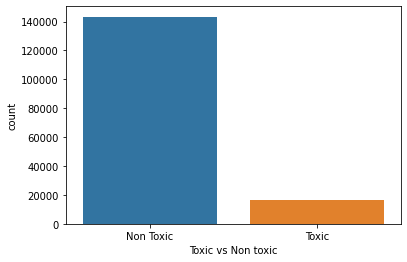

In [15]:
## to visualize the number of Toxic vs Non toxic comments in the dataset
ax = sns.countplot(toxic_data.overall)
plt.xlabel('Toxic vs Non toxic')
ax.set_xticklabels(['Non Toxic', 'Toxic'])

We can see the dataset is not balanced.

In [16]:
## dataframe with all toxic comments
toxic_train_df = toxic_data[toxic_data.overall == 1]
## dataframe with all non-toxic comments
nontoxic_train_df = toxic_data[toxic_data.overall == 0]
toxic_train_df.shape, nontoxic_train_df.shape

((16225, 8), (143346, 8))

In [17]:
## Here we have taken sample of 16000 from each toxic_train_df and nontoxic_train_df 
sample = 16000
toxic_train_df = toxic_train_df.sample(frac=1).reset_index(drop=True)
nontoxic_train_df = nontoxic_train_df.sample(frac=1).reset_index(drop=True)

new_train_df = pd.concat([toxic_train_df[:sample], nontoxic_train_df[:sample]])
new_train_df = new_train_df.sample(frac=1).reset_index(drop=True)
new_train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,overall
0,Specific Quranic content In further response ...,0,0,0,0,0,0,0
1,Just to be 100 sure I understand When you ...,0,0,0,0,0,0,0
2,Good Luck wikipedia sucks 71186170196 Oo...,1,0,1,0,0,0,1
3,Not understood What should they say about whet...,0,0,0,0,0,0,0
4,Malfunctioning archive bot and improper arch...,0,0,0,0,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Non Toxic'), Text(0, 0, 'Toxic')]

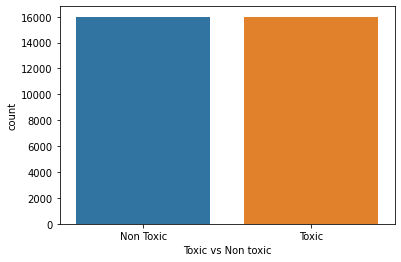

In [18]:
## after sampling ,visualization of number of Toxic vs Non toxic comments in the dataset.
ax = sns.countplot(new_train_df.overall)
plt.xlabel('Toxic vs Non toxic')
ax.set_xticklabels(['Non Toxic', 'Toxic'])

From the above barplot we can see the data is balanced now.

In [19]:
##  libraries for modeling
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizerFast, BertForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [20]:
## initialize tokanizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

In [21]:
#splitting the dataset into x and y and train-test-split
comments = new_train_df['comment_text'].values.tolist()
labels = new_train_df['overall'].values.tolist()
(train_texts,valid_texts,train_labels,valid_labels)=train_test_split(comments, labels, test_size=0.3)

In [22]:
## apply the tokanizer to training comment and testing comment
X_train_tokenized = tokenizer(train_texts, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(valid_texts, padding=True, truncation=True, max_length=512)

In [23]:
### Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


In [24]:
## prepared dataset
train_dataset = Dataset(X_train_tokenized, train_labels)
val_dataset = Dataset(X_val_tokenized, valid_labels)

In [25]:
## to compute accuracy matrix
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [26]:
## initialize bert model for classificaion
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="/content/drive/MyDrive/NLP projects/Toxic comment detection/Output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    seed=0,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics)

# Train pre-trained model
trainer.train()

***** Running training *****
  Num examples = 22400
  Num Epochs = 2
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 22400


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.617500,0.356057,0.898333,0.878941,0.920229,0.899111
1000,0.548200,0.571721,0.910104,0.898658,0.921287,0.909832


***** Running Evaluation *****
  Num examples = 9600
  Batch size = 2
Saving model checkpoint to /content/drive/MyDrive/NLP projects/Toxic comment detection/Output/checkpoint-500
Configuration saved in /content/drive/MyDrive/NLP projects/Toxic comment detection/Output/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/NLP projects/Toxic comment detection/Output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 9600
  Batch size = 2
Saving model checkpoint to /content/drive/MyDrive/NLP projects/Toxic comment detection/Output/checkpoint-1000
Configuration saved in /content/drive/MyDrive/NLP projects/Toxic comment detection/Output/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/NLP projects/Toxic comment detection/Output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 9600
  Batch size = 2
